In [1]:
using Plots

mutable struct FVM
    # lattice parameters
    N::Int
    Xl::Float64
    Xr::Float64
    dx::Float64
    x                   # coordinate of boundary

    # time parameters
    dt::Float64         # time step width
    t::Float64          # time
    n::Int              # step counter

    # hyper parameter
    cfl::Float64        # CFL number: 0 < cfl < 1

    # physical parameter
    γ::Float64          # heat capacity ratio of ideal gas

    # mean value of cells
    density
    momentum
    ρE

    # value of cells (reservor)
    _density
    _momentum
    _ρE

    # values of cell boundary
    density_L
    density_R
    momentum_L
    momentum_R
    ρE_L
    ρE_R

    # numerical flux of cell boundaries
    density_flux
    momentum_flux
    ρE_flux

    # flux (reservor)
    _density_flux
    _momentum_flux
    _ρE_flux

    # constructor
    function FVM(density_init, pressure_init, velocity_init; N, Xl, Xr, γ=1.4, cfl=0.4)
        t = 0.0
        n = 0
        dx = (Xr - Xl) / N
        dt = dx * cfl
        x = [Xl + i * dx for i = 1 : N]
        density = density_init.(x)
        pressure = pressure_init.(x)
        velocity = velocity_init.(x)
        momentum = density .* velocity      # product by component
        ρE =  0.5 .* momentum .* velocity + pressure ./ (γ - 1.0)
        _density = zeros(N)
        _momentum = zeros(N)
        _ρE = zeros(N)
        density_L = zeros(N+1)
        density_R = zeros(N+1)
        momentum_L = zeros(N+1)
        momentum_R = zeros(N+1)
        ρE_L = zeros(N+1)
        ρE_R = zeros(N+1)
        density_flux = zeros(N+1)
        momentum_flux = zeros(N+1)
        ρE_flux = zeros(N+1)
        _density_flux = zeros(N+1)
        _momentum_flux = zeros(N+1)
        _ρE_flux = zeros(N+1)
        new(N, Xl, Xr, dx, x, dt, t, n, cfl, γ, density, momentum, ρE, _density, _momentum, _ρE,
            density_L, density_R, momentum_L, momentum_R, ρE_L, ρE_R, density_flux, momentum_flux, ρE_flux, _density_flux, _momentum_flux, _ρE_flux)
    end
end

function dt_update!(fvm)
    maximal_characteristic_velocity = 0.1       # minimal value for numerical stability
    for i = 1 : fvm.N
        velocity = fvm.momentum[i] / fvm.density[i]
        pressure = (fvm.γ - 1.0) * (fvm.ρE[i] - 0.5 * fvm.momentum[i] * velocity)
        sound = sqrt(fvm.γ * pressure / fvm.density[i])
        maximal_characteristic_velocity = max(maximal_characteristic_velocity, abs(velocity + sound), abs(velocity - sound))
    end
    fvm.dt = fvm.cfl * fvm.dx / maximal_characteristic_velocity
end

# spacial reconstruction methods
function reconstruction!(fvm, rec)
    for i = 2 : fvm.N - 2
        fvm.density_L[i+1] = fvm.density[i] + 0.5 * (fvm.density[i+1] - fvm.density[i]) * _limitor(fvm, i, rec, "density", "left")
        fvm.density_R[i+1] = fvm.density[i+1] - 0.5 * (fvm.density[i+1] - fvm.density[i]) * _limitor(fvm, i, rec, "density", "right")
        fvm.momentum_L[i+1] = fvm.momentum[i] + 0.5 * (fvm.momentum[i+1] - fvm.momentum[i]) * _limitor(fvm, i, rec, "momentum", "left")
        fvm.momentum_R[i+1] = fvm.momentum[i+1] - 0.5 * (fvm.momentum[i+1] - fvm.momentum[i]) * _limitor(fvm, i, rec, "momentum", "right")
        fvm.ρE_L[i+1] = fvm.ρE[i] + 0.5 * (fvm.ρE[i+1] - fvm.ρE[i]) * _limitor(fvm, i, rec, "ρE", "left")
        fvm.ρE_R[i+1] = fvm.ρE[i+1] - 0.5 * (fvm.ρE[i+1] - fvm.ρE[i]) * _limitor(fvm, i, rec, "ρE", "right")
    end
end

function _limitor(fvm, i, rec, _type, _direction; ϵ=0.00000001)
    if rec == "minmod"
        limitor = (x -> max(0.0, min(1.0, x)))
    elseif rec == "van_Leer"
        limitor = (x -> (x + abs(x)) / (1.0 + abs(x)))
    elseif rec == "van_Albada"
        limitor = (x -> (x + x^2) / (1.0 + x^2))
    elseif rec == "superbee"
        limitor = (x -> max(0.0, min(1.0, 2.0 * x), min(2.0, x)))
    elseif rec == "Lax_Wendroff"
        limitor = 1.0
    elseif rec == "linear"
        limitor = 0.0
    else
        error("invalid limitor: $rec")
    end

    if _type == "density"
        ρ = fvm.density
    elseif _type == "momentum"
        ρ = fvm.momentum
    elseif _type == "ρE"
        ρ = fvm.ρE
    end

    if _direction == "left"
        Δ = ρ[i] - ρ[i-1]
    elseif _direction == "right"
        Δ = ρ[i+2] - ρ[i+1]
    end

    if abs(ρ[i+1] - ρ[i]) < ϵ
        return limitor(1.0)
    else
        return limitor(Δ / (ρ[i+1] - ρ[i]))
    end
end

# Riemann solver methods
function flux_vector_splitting!(fvm)        # Stagger-Warming method
    for i = 3 : fvm.N - 1
        # primitive variables
        velocity_L = fvm.momentum_L[i] / fvm.density_L[i]
        velocity_R = fvm.momentum_R[i] / fvm.density_R[i]
        pressure_L = (fvm.γ - 1.0) * (fvm.ρE_L[i] - 0.5 * fvm.momentum_L[i] * velocity_L)
        pressure_R = (fvm.γ - 1.0) * (fvm.ρE_R[i] - 0.5 * fvm.momentum_R[i] * velocity_R)
        sound_L = sqrt(fvm.γ * pressure_L / fvm.density_L[i])
        sound_R = sqrt(fvm.γ * pressure_R / fvm.density_R[i])

        # characteristic velocity
        λ1_L = max(0.0, velocity_L)
        λ2_L = max(0.0, velocity_L + sound_L)
        λ3_L = max(0.0, velocity_L - sound_L)
        λ1_R = min(0.0, velocity_R)
        λ2_R = min(0.0, velocity_R + sound_R)
        λ3_R = min(0.0, velocity_R - sound_R)

        # flux
        c1L = (fvm.γ - 1.0) / fvm.γ * fvm.density_L[i] * λ1_L
        c2L = 0.5 * fvm.density_L[i] / fvm.γ * λ2_L
        c3L = 0.5 * fvm.density_L[i] / fvm.γ * λ3_L
        flux_1_L = c1L + c2L + c3L
        flux_2_L = c1L * velocity_L + c2L * (velocity_L + sound_L) + c3L * (velocity_L - sound_L)
        flux_3_L = c1L * velocity_L^2 * 0.5 + c2L * (0.5 * velocity_L ^ 2 + sound_L ^ 2 / (fvm.γ - 1.0) + velocity_L * sound_L) + c3L * (0.5 * velocity_L ^ 2 + sound_L ^ 2 / (fvm.γ - 1.0) - velocity_L * sound_L)
        c1R = (fvm.γ - 1.0) / fvm.γ * fvm.density_R[i] * λ1_R
        c2R = 0.5 * fvm.density_R[i] / fvm.γ * λ2_R
        c3R = 0.5 * fvm.density_R[i] / fvm.γ * λ3_R
        flux_1_R = c1R + c2R + c3R
        flux_2_R = c1R * velocity_R + c2R * (velocity_R + sound_R) + c3R * (velocity_R - sound_R)
        flux_3_R = c1R * velocity_R^2 * 0.5 + c2R * (0.5 * velocity_R ^ 2 + sound_R ^ 2 / (fvm.γ - 1.0) + velocity_R * sound_R) + c3R * (0.5 * velocity_R ^ 2 + sound_R ^ 2 / (fvm.γ - 1.0) - velocity_R * sound_R)

        fvm.density_flux[i] = flux_1_L + flux_1_R
        fvm.momentum_flux[i] = flux_2_L + flux_2_R
        fvm.ρE_flux[i] = flux_3_L + flux_3_R
    end

    # interpolation
    fvm.density_flux[2] = fvm.density_flux[3]
    fvm.momentum_flux[2] = fvm.momentum_flux[3]
    fvm.ρE_flux[2] = fvm.ρE_flux[3]
    fvm.density_flux[1] = fvm.density_flux[2]
    fvm.momentum_flux[1] = fvm.momentum_flux[2]
    fvm.ρE_flux[1] = fvm.ρE_flux[2]
    fvm.density_flux[fvm.N] = fvm.density_flux[fvm.N-1]
    fvm.momentum_flux[fvm.N] = fvm.momentum_flux[fvm.N-1]
    fvm.ρE_flux[fvm.N] = fvm.ρE_flux[fvm.N-1]
    fvm.density_flux[fvm.N+1] = fvm.density_flux[fvm.N]
    fvm.momentum_flux[fvm.N+1] = fvm.momentum_flux[fvm.N]
    fvm.ρE_flux[fvm.N+1] = fvm.ρE_flux[fvm.N]
end

function flux_difference_splitting!(fvm; ϵ=0.15)        # Roe-Harten Riemann solver; ϵ: Harten's parameter
    Harten_modification = (λ -> abs(λ) < 2.0 * ϵ ? λ^2 / (4.0 * ϵ) + ϵ : abs(λ))

    for i = 3 : fvm.N - 1
        # primitive variables
        velocity_L = fvm.momentum_L[i] / fvm.density_L[i]
        velocity_R = fvm.momentum_R[i] / fvm.density_R[i]
        pressure_L = (fvm.γ - 1.0) * (fvm.ρE_L[i] - 0.5 * fvm.momentum_L[i] * velocity_L)
        pressure_R = (fvm.γ - 1.0) * (fvm.ρE_R[i] - 0.5 * fvm.momentum_R[i] * velocity_R)
        enthalpy_L = (fvm.ρE_L[i] + pressure_L) / fvm.density_L[i]
        enthalpy_R = (fvm.ρE_R[i] + pressure_R) / fvm.density_R[i]

        # Roe average
        ρL_sqrt = sqrt(fvm.density_L[i])
        ρR_sqrt = sqrt(fvm.density_R[i])
        density_avg = ρL_sqrt * ρR_sqrt
        velocity_avg = (velocity_L * ρL_sqrt + velocity_R * ρR_sqrt) / (ρL_sqrt + ρR_sqrt)
        enthalpy_avg = (enthalpy_L * ρL_sqrt + enthalpy_R * ρR_sqrt) / (ρL_sqrt + ρR_sqrt)
        sound_avg = sqrt((fvm.γ - 1.0) * (enthalpy_avg - 0.5 * velocity_avg ^ 2))

        # characteristic velocity (with Harten's entropic modification)
        λ1 = Harten_modification(velocity_avg)
        λ2 = Harten_modification(velocity_avg + sound_avg)
        λ3 = Harten_modification(velocity_avg - sound_avg)

        # flux
        c1 = fvm.density_R[i] - fvm.density_L[i] - (pressure_R - pressure_L) / sound_avg ^ 2
        c2 = 0.5 * density_avg / sound_avg * (velocity_R - velocity_L + (pressure_R - pressure_L) / (density_avg * sound_avg))
        c3 = 0.5 * density_avg / sound_avg * (-(velocity_R - velocity_L) + (pressure_R - pressure_L) / (density_avg * sound_avg))
        fvm.density_flux[i] = 0.5 * (fvm.density_L[i] * velocity_L + fvm.density_R[i] * velocity_R - c1 * λ1 - c2 * λ2 - c3 * λ3)
        fvm.momentum_flux[i] = 0.5 * (fvm.density_L[i] * velocity_L ^ 2 + pressure_L + fvm.density_R[i] * velocity_R ^ 2 + pressure_R
                                      - c1 * λ1 * velocity_avg - c2 * λ2 * (velocity_avg + sound_avg) - c3 * λ3 * (velocity_avg - sound_avg))
        fvm.ρE_flux[i] = 0.5 * (fvm.ρE_L[i] * velocity_L + pressure_L * velocity_L + fvm.ρE_R[i] * velocity_R + pressure_R * velocity_R
                                - 0.5 * c1 * λ1 * velocity_avg ^ 2 - c2 * λ2 * (enthalpy_avg + sound_avg * velocity_avg) - c3 * λ3 * (enthalpy_avg - sound_avg * velocity_avg))
    end

    # interpolation
    fvm.density_flux[2] = fvm.density_flux[3]
    fvm.momentum_flux[2] = fvm.momentum_flux[3]
    fvm.ρE_flux[2] = fvm.ρE_flux[3]
    fvm.density_flux[1] = fvm.density_flux[2]
    fvm.momentum_flux[1] = fvm.momentum_flux[2]
    fvm.ρE_flux[1] = fvm.ρE_flux[2]
    fvm.density_flux[fvm.N] = fvm.density_flux[fvm.N-1]
    fvm.momentum_flux[fvm.N] = fvm.momentum_flux[fvm.N-1]
    fvm.ρE_flux[fvm.N] = fvm.ρE_flux[fvm.N-1]
    fvm.density_flux[fvm.N+1] = fvm.density_flux[fvm.N]
    fvm.momentum_flux[fvm.N+1] = fvm.momentum_flux[fvm.N]
    fvm.ρE_flux[fvm.N+1] = fvm.ρE_flux[fvm.N]
end

function Runge_Kutta_first!(fvm)
    for i = 1 : fvm.N
        fvm._density[i] = fvm.density[i]
        fvm._momentum[i] = fvm.momentum[i]
        fvm._ρE[i] = fvm.ρE[i]
        fvm._density_flux[i] = fvm.density_flux[i]
        fvm._momentum_flux[i] = fvm.momentum_flux[i]
        fvm._ρE_flux[i] = fvm.ρE_flux[i]
        fvm.density[i] -= fvm.dt / fvm.dx * (fvm.density_flux[i+1] - fvm.density_flux[i])
        fvm.momentum[i] -= fvm.dt / fvm.dx * (fvm.momentum_flux[i+1] - fvm.momentum_flux[i])
        fvm.ρE[i] -= fvm.dt / fvm.dx * (fvm.ρE_flux[i+1] - fvm.ρE_flux[i])
    end
end

function Runge_Kutta_second!(fvm)
    for i = 1 : fvm.N
        fvm.density[i] = fvm._density[i] - 0.5 * fvm.dt / fvm.dx * ((fvm.density_flux[i+1] - fvm.density_flux[i]) + (fvm._density_flux[i+1] - fvm._density_flux[i]))
        fvm.momentum[i] = fvm._momentum[i] - 0.5 * fvm.dt / fvm.dx * ((fvm.momentum_flux[i+1] - fvm.momentum_flux[i]) + (fvm._momentum_flux[i+1] - fvm._momentum_flux[i]))
        fvm.ρE[i] = fvm._ρE[i] - 0.5 * fvm.dt / fvm.dx * ((fvm.ρE_flux[i+1] - fvm.ρE_flux[i]) + (fvm._ρE_flux[i+1] - fvm._ρE_flux[i]))
    end
end

function boundary_condition!(fvm)
    fvm.momentum[fvm.N] = fvm.momentum[fvm.N - 1]
end

# main loop
function solve!(fvm, t_stop; rec="minmod", solver="vec")
    Riemann_solver = _solver_selection(solver)

    while fvm.t <= t_stop
        fvm.t += fvm.dt
        fvm.n += 1
        dt_update!(fvm)
        reconstruction!(fvm, rec)
        Riemann_solver(fvm)
        Runge_Kutta_first!(fvm)
        reconstruction!(fvm, rec)
        Riemann_solver(fvm)
        Runge_Kutta_second!(fvm)
        boundary_condition!(fvm)
    end
    show_parameters(fvm)
end

function _solver_selection(solver)
    if solver == "vec"
        return flux_vector_splitting!
    elseif solver == "dif"
        return flux_difference_splitting!
    else
        error("invalid solver: $solver")
    end
end

function show_parameters(fvm)
    println("N = $(fvm.N)\n[Xl, Xr] = [$(fvm.Xl), $(fvm.Xr)], dx = $(fvm.dx)\nt = $(fvm.t), steps = $(fvm.n)\nCFL = $(fvm.cfl)\nheat capacity ratio of ideal gas = $(fvm.γ)")
end

##################################################################################################
# Sod's benchmark problem
density_init(x) = x > 0.0 ? 0.125 : 1.0
pressure_init(x) = x > 0.0 ? 0.1 : 1.0
velocity_init(x) = 0.0

function explicit_solution_of_Sod_problem(fvm)
    speed_of_sound = ((p, ρ) -> sqrt(fvm.γ * p / ρ))
    x_0 = 0.0

    # domain 1
    density_1 = 0.125
    pressure_1 = 0.1
    velocity_1 = 0.0
    sound_1 = speed_of_sound(pressure_1, density_1)

    # domain 5
    density_5 = 1.0
    pressure_5 = 1.0
    velocity_5 = 0.0
    sound_5 = speed_of_sound(pressure_5, density_5)

    p_ratio = _pressure_ratio(pressure_1, pressure_5, sound_1, sound_5, velocity_1, velocity_5, fvm.γ)

    # domain 2
    density_2 = density_1 * (p_ratio + (fvm.γ - 1.0) / (fvm.γ + 1.0)) / (p_ratio * (fvm.γ - 1.0) / (fvm.γ + 1.0) + 1.0)
    velocity_2 = velocity_1 + sound_1 * sqrt(2.0 / fvm.γ) * (p_ratio - 1.0) / sqrt(fvm.γ - 1.0 + p_ratio * (fvm.γ + 1.0))
    pressure_2 = p_ratio * pressure_1

    # domain 3
    velocity_3 = velocity_2
    pressure_3 = pressure_2
    density_3 = density_5 * (pressure_3 / pressure_5) ^ (1.0 / fvm.γ)
    sound_3 = speed_of_sound(pressure_3, density_3)

    # wave velocity
    V_shock = velocity_1 + sound_1 * sqrt((fvm.γ + 1.0) / (2.0 * fvm.γ) * (p_ratio - 1.0) + 1.0)
    V_contact = velocity_3
    V_expansion_R = velocity_3 - sound_3
    V_expansion_L = velocity_5 - sound_5

    # wave position at t = fvm.t
    X_shock = x_0 + V_shock * fvm.t
    X_contact = x_0 + V_contact * fvm.t
    X_expansion_R = x_0 + V_expansion_R * fvm.t
    X_expansion_L = x_0 + V_expansion_L * fvm.t

    density = zeros(fvm.N)
    pressure = zeros(fvm.N)
    velocity = zeros(fvm.N)
    for i = 1 : fvm.N
        if fvm.x[i] < X_expansion_L         # domain 5
            density[i] = density_5
            pressure[i] = pressure_5
            velocity[i] = velocity_5
        elseif fvm.x[i] < X_expansion_R     # domain 4
            velocity[i] = 2.0 / (fvm.γ + 1.0) * (0.5 * (fvm.γ - 1.0) * velocity_5 + sound_5 + (fvm.x[i] - x_0) / fvm.t)
            sound_4 = sound_5 - 0.5 * (fvm.γ - 1.0) * (velocity[i] - velocity_5)
            pressure[i] = pressure_5 * (sound_4 / sound_5) ^ (2.0 * fvm.γ / (fvm.γ - 1.0))
            density[i] = density_5 * (pressure[i] / pressure_5) ^ (1.0 / fvm.γ)
        elseif fvm.x[i] < X_contact         # domain 3
            density[i] = density_3
            pressure[i] = pressure_3
            velocity[i] = velocity_3
        elseif fvm.x[i] < X_shock           # domain 2
            density[i] = density_2
            pressure[i] = pressure_2
            velocity[i] = velocity_2
        else                                # domain 1
            density[i] = density_1
            pressure[i] = pressure_1
            velocity[i] = velocity_1
        end
    end

    return (density = density, pressure = pressure, velocity = velocity)
end

# pressure ratio calculation by Secant method
function _pressure_ratio(pressure_1, pressure_5, sound_1, sound_5, velocity_1, velocity_5, γ; iter_max=20, ϵ=0.00001)
    F = ((p21, p1, p5) -> p5 / p1 * (1.0 + (γ - 1.0)/2.0/sound_5 * (velocity_5 - velocity_1 - sound_1*(p21-1.0)/γ / sqrt((γ+1.0)/2.0/γ * (p21 - 1.0) + 1.0)))^(2.0*γ/(γ-1.0)) - p21)

    p_ratio = pressure_1 / pressure_5
    pm = p_ratio + 0.01
    pmm = pm + 0.01
    fmm = F(pm, pressure_1, pressure_5)

    for _ = 1 : iter_max
        fm = F(p_ratio, pressure_1, pressure_5)
        p_ratio -= (p_ratio - pmm) / _delta(fm - fmm) * fm

        if (abs(p_ratio - pm) / pm) < ϵ
            break
        end

        pmm = pm
        pm = p_ratio
        fmm = fm
    end

    return p_ratio
end

function _delta(x, ϵ=0.00000001)
    return abs(x) > ϵ ? x : ϵ * sign(x)
end

function show_Sod(fvm)
    plot(fvm.x, fvm.density, xlabel="x", label="Riemann_solver", title="density of ideal fluid: Sod problem")
    explicit_solution = explicit_solution_of_Sod_problem(fvm)
    plot!(fvm.x, explicit_solution.density, label="explicit_solution")
end

show_Sod (generic function with 1 method)

In [2]:
function show_pressure(fvm)
    pressure = zeros(fvm.N)
    for i = 1 : fvm.N
        pressure[i] = (fvm.γ - 1.0) * (fvm.ρE[i] - 0.5 * fvm.momentum[i] * fvm.momentum[i] / fvm.density[i])
    end
    plot(pressure)
end

show_pressure (generic function with 1 method)

In [3]:
N = 100
Xl = -1.0
Xr = 1.0
gamma = 1.4
cfl = 0.5
t_stop = 0.48

0.48

N = 100
[Xl, Xr] = [-1.0, 1.0], dx = 0.02
t = 0.4828632889305565, steps = 129
CFL = 0.4
heat capacity ratio of ideal gas = 1.4


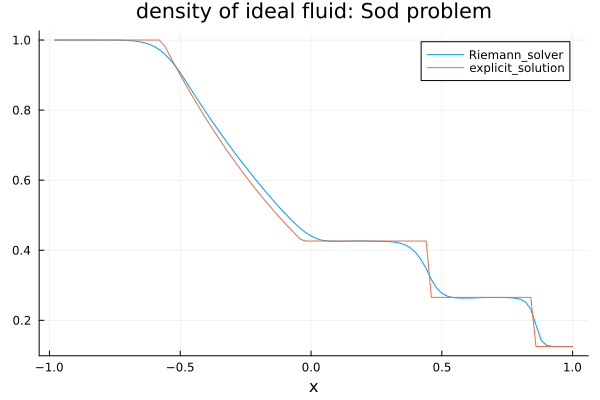

In [5]:
fvm = FVM(density_init, pressure_init, velocity_init, N=N, Xl=Xl, Xr=Xr)
solve!(fvm, t_stop)
show_Sod(fvm)

N = 100
[Xl, Xr] = [-1.0, 1.0], dx = 0.02
t = 0.4800681750749302, steps = 128
CFL = 0.4
heat capacity ratio of ideal gas = 1.4


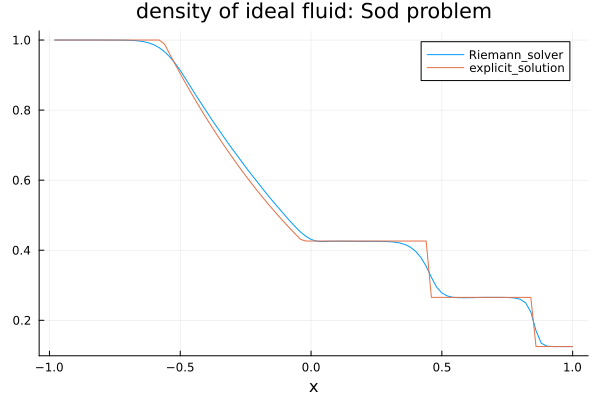

In [12]:
fvm2 = FVM(density_init, pressure_init, velocity_init, N=N, Xl=Xl, Xr=Xr)
solve!(fvm2, t_stop, solver="dif")
show_Sod(fvm2)

N = 100
[Xl, Xr] = [-1.0, 1.0], dx = 0.02
t = 0.4808566124316035, steps = 129
CFL = 0.4
heat capacity ratio of ideal gas = 1.4


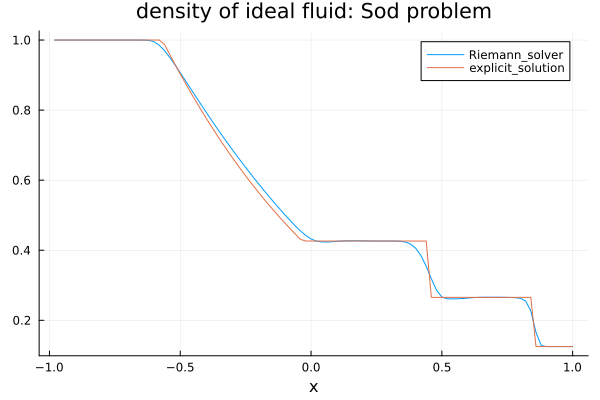

In [16]:
fvm3 = FVM(density_init, pressure_init, velocity_init, N=N, Xl=Xl, Xr=Xr)
solve!(fvm3, t_stop, rec="van_Leer")
show_Sod(fvm3)

N = 100
[Xl, Xr] = [-1.0, 1.0], dx = 0.02
t = 0.4815879397185456, steps = 129
CFL = 0.4
heat capacity ratio of ideal gas = 1.4


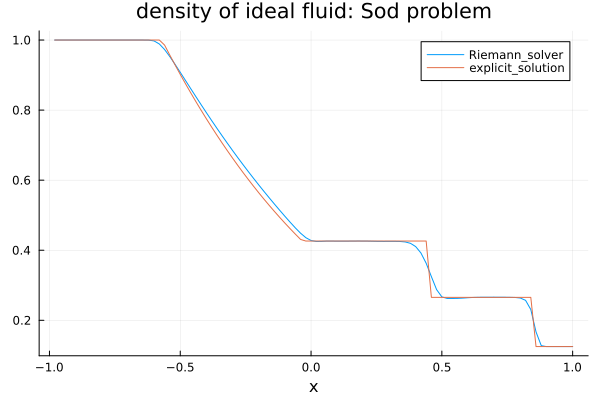

In [17]:
fvm4 = FVM(density_init, pressure_init, velocity_init, N=N, Xl=Xl, Xr=Xr)
solve!(fvm4, t_stop, rec="van_Leer", solver="dif")
show_Sod(fvm4)